In [1]:
import sys
import os
import itertools

import numpy as np
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import plotutils as pu
import util


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Matplotlib config

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [3]:
! ls ../run/hcp/hcp100_linw_dicer/

dataset.npz  img  modelAB  modelAN  surrogates.npz


In [4]:
conn = "linw"
preproc = "dicer"
modelname1 = "AN"
modelname2 = "AB"
config = "ns_3_mreg_3_msub_0_nf_32"
isub = 5

In [5]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")

run1 = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname1, config, [0,1], "hcp")
run2 = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname2, config, [0,1], "hcp")

direc1 = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname1}/{config}/run{run1:02d}"
direc2 = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname2}/{config}/run{run2:02d}"

sims1 = ndsv.GeneratedData.from_file(os.path.join(direc1, f"simulations/simulations_{isub:03d}.npz"))    
sims2 = ndsv.GeneratedData.from_file(os.path.join(direc2, f"simulations/simulations_{isub:03d}.npz"))

params1 = util.load_params(os.path.join(direc1, "parameters"), subjects=range(0,100))
params2 = util.load_params(os.path.join(direc1, "parameters"), subjects=range(0,100))

model1 = util.get_model(modelname1, config, ds)
model1.load_weights(os.path.join(direc1, "fit/model"))

model2 = util.get_model(modelname2, config, ds)
model2.load_weights(os.path.join(direc2, "fit/model"))

nt = ds.y.shape[-1]

2022-08-30 19:37:33.435276: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 19:37:33.458516: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3399905000 Hz
2022-08-30 19:37:33.459024: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562813ae95f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-30 19:37:33.459044: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-30 19:37:33.459148: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### FC similarity

In [6]:
def get_fc_similarity(preproc, config, models):
    nreg = 68
    nsub = 100
    nsamples = 50
    nmodels = len(models)
    
    runs = np.array([util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp") 
                     for conn, modelname in models])
    
    pc = np.zeros((nmodels, nsub, nsamples))
    
    for i, (conn, model) in enumerate(models):
        fc = np.load(
            f"../run/hcp/hcp100_{conn}_{preproc}/model{model}/{config}/run{runs[i]:02d}/simulations/fc.npz")
        pc[i] = fc['similarity']
                
    return pc        
        
conns = ['linw', 'linwhom', 'logw', 'logwhom']
modelnames = ['AB', 'AN']
models = [(conn, model) for model in modelnames for conn in conns]

fc_pc = get_fc_similarity(preproc, config, models)

/tmp/ipykernel_14776/1725410290.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


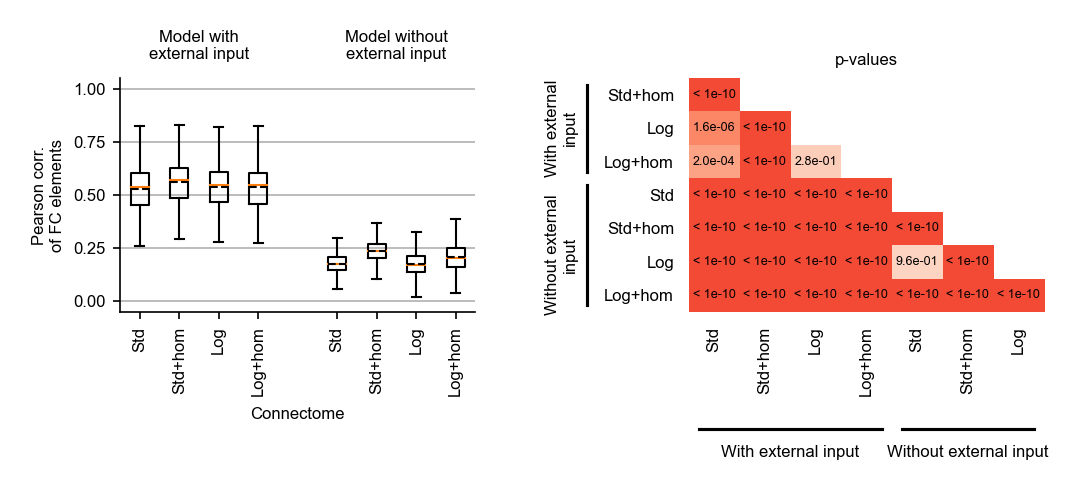

In [105]:
def plot_fc_similarity(ax, pc1, pc2, models, connlabels):
    nconns, nsub, nsamples = pc1.shape
    space = 1
    nsub_example = 20
    
    color1 = '0.0'
    color2 = '0.5'
    
    for k, pc in enumerate([pc1, pc2]):        
        plt.boxplot([pc[i,:,:].ravel() for i in range(nconns)], positions=np.r_[k+k*nconns:k+(k+1)*nconns],
                   showfliers=False, showmeans=True, meanline=True, meanprops={'color': 'k'})

    plt.ylabel('Pearson corr.\nof FC elements')
    plt.ylim(-0.05, 1.05)
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    
    labelpos = np.concatenate([np.r_[:nconns], np.r_[:nconns] + nconns + space])
    labels = np.concatenate([connlabels, connlabels])
    
    plt.xticks(labelpos, labels, rotation='vertical')
    plt.xlabel("Connectome", labelpad=5)
    
    plt.grid(axis='y', zorder=-10)
    pu.bottomleft_spines(ax)
    
    plt.text(1.5, 1.2, "Model with\nexternal input", ha='center', va='center', fontsize=8)
    plt.text(nconns+space+1.5, 1.2, "Model without\nexternal input", ha='center', va='center', fontsize=8)


def add_newline(s):
    return s[:s.rfind(" ")] + '\n' + s[s.rfind(" ")+1:]
    
def plot_pvals(ax, pvals, connlabels, modlabels):
    plt.title("p-values")
    plt.imshow(np.log10(pvals.T+1e-10), vmin=-20, vmax=4, cmap='Reds_r', aspect='auto')
    for i in range(n):
        for j in range(n):
            if j > i:
                ptext = f"{pvals[i,j]:.1e}" if pvals[i,j] >= 1e-10 else "< 1e-10"
                plt.text(i, j, ptext, ha='center', va='center', fontsize=6)

    labels = [c for m in modellabels for c in connlabels]
    plt.xticks(np.r_[:n], labels, rotation='vertical')
    plt.yticks(np.r_[:n], labels);
    
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 

    plt.xlim(-0.5,6.5)
    plt.ylim(7.5,0.5)    
    
    plt.text(1.5, 11.7, modlabels[0], ha='center', va='center')
    plt.text(5., 11.7, modlabels[1], ha='center', va='center')
    plt.plot([-0.3, 3.3], [11., 11], color='k', clip_on=False)
    plt.plot([3.7, 6.3], [11., 11], color='k', clip_on=False)
    
    
    plt.text(-3, 2,   add_newline(modlabels[0]), ha='center', va='center', rotation='vertical')
    plt.text(-3, 5.8, add_newline(modlabels[1]), ha='center', va='center', rotation='vertical')
    plt.plot([-2.5, -2.5], [0.7, 3.3], color='k', clip_on=False)
    plt.plot([-2.5, -2.5], [3.7, 7.3], color='k', clip_on=False)
    

connlabels = ["Std", "Std+hom", "Log", "Log+hom"]
    
plt.figure(figsize=(7.0,3.0), dpi=150)
gs = gridspec.GridSpec(nrows=1, ncols=2, wspace=0.6, width_ratios=[1,1], right=0.98, left=0.1,
                       top=0.86, bottom=0.34)

ax = plt.subplot(gs[0])
plot_fc_similarity(ax, fc_pc[:4], fc_pc[4:], models, connlabels)

ax = plt.subplot(gs[1])
plot_pvals(ax, pvals, connlabels, ["With external input", "Without external input"])

plt.tight_layout()
bg = pu.Background(visible=False)
plt.savefig("img/Fig_HCP-connectome.pdf")

In [91]:

s

'With external\ninput'

## Statistics

In [8]:
x = fc_pc.reshape((2*len(conns), -1))

n = len(x)
pvals = np.full((n,n), np.nan)

for i in range(n):
    for j in range(i+1, n):
        tval, pvals[i,j] = stats.ttest_ind(x[i], x[j])

In [32]:
modellabels = ["With input", "Without input"]
connlabels = ["Std", "Std+hom", "Log", "Log+hom"]
# labels = [m + ", " + c for m in modellabels for c in connlabels]
labels = [c for m in modellabels for c in connlabels]

(7.5, 0.5)

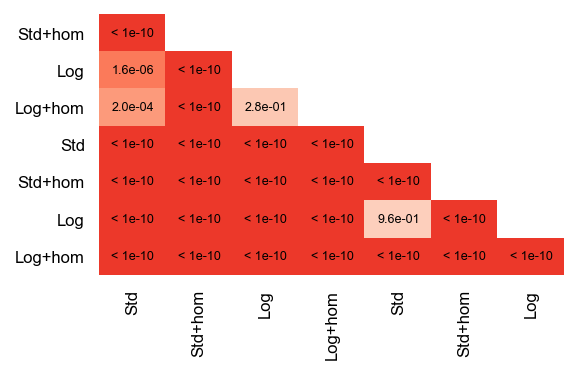

In [46]:
# current_cmap = matplotlib.cm.get_cmap()
# current_cmap.set_bad(color='0.7')


In [11]:
for i, l in enumerate(labels):
    print(f"{l:25}:   {np.mean(x[i]):.5f}")

With input, Std          :   0.52923
With input, Std+hom      :   0.55931
With input, Log          :   0.53884
With input, Log+hom      :   0.53672
Without input, Std       :   0.17754
Without input, Std+hom   :   0.23717
Without input, Log       :   0.17748
Without input, Log+hom   :   0.21083
